In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [5]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [6]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
106320,69591338,Production Manager,"Pressurefab Group , the fastest growing steel ...",Dundee Angus Scotland,UK,NaN,permanent,Pressurefab Group Ltd,"Energy, Oil & Gas Jobs","40,000 per annum",40000,totaljobs.com
29833,68057787,Electrical Manufacturing Technicians,Electrical Manufacturing Technicians : World c...,Stevenage Hertfordshire South East,UK,NaN,contract,Mass Consultants Ltd,Other/General Jobs,16.50 per hour,31680,totaljobs.com
192372,71759666,Infrastructure Project Manager Bristol,Infrastructure Project Manager Commutable from...,Bristol Avon South West,UK,NaN,permanent,Redrock Consulting Ltd,IT Jobs,27000 - 30000 per annum + Good Benefits Package,28500,cwjobs.co.uk


In [7]:
from sklearn.preprocessing import KBinsDiscretizer
data["log_salary"] = np.log(data["SalaryNormalized"])
kb = KBinsDiscretizer(
    n_bins=5, 
    encode="ordinal", 
    strategy="quantile"
).fit(data[["log_salary"]])
data["log_salary_cat"] = kb.transform(data[["log_salary"]]).ravel()
data["Category_temp"] = data["Category"]
data["Category_temp"].replace({"Domestic help & Cleaning Jobs" : "Other", "Part time Jobs": "Other"}, inplace=True)

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [8]:
from sklearn.model_selection import train_test_split
y = data["log_salary"]
X = data.drop(columns=["log_salary", "log_salary_cat", "Category_temp", "SalaryRaw", "SalaryNormalized"])
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42,
    stratify=data[["Category_temp", "log_salary_cat"]]
)

In [30]:
X_train["Title"].fillna("", inplace=True)
X_train["FullDescription"].fillna("", inplace=True)
X_val["Title"].fillna("", inplace=True)
X_val["FullDescription"].fillna("", inplace=True)

In [31]:
X_train["text"] = X_train[["Title", "FullDescription"]].apply(lambda t: t["Title"] + t["FullDescription"], axis=1)
X_val["text"] = X_val[["Title", "FullDescription"]].apply(lambda t: t["Title"] + t["FullDescription"], axis=1)

In [11]:
X_train[["text", "Title", "FullDescription"]]

,text,Title,FullDescription
133212,Senior Sales ExecutiveSenior Sales Executive ...,Senior Sales Executive,Senior Sales Executive Umbrella and Payroll S...
105742,Digital Account Manager Leading Global Consum...,Digital Account Manager Leading Global Consum...,As Digital Account Manager you will be the int...
67276,GPST**** General Medicine LASGPST**** General ...,GPST**** General Medicine LAS,GPST**** General Medicine Locum Appointment fo...
217942,"Software Support Engineer, DorsetA leading har...","Software Support Engineer, Dorset",A leading hardware and software company servic...
139748,Design Engineer Catia SPMMechanical Design E...,Design Engineer Catia SPM,Mechanical Design Engineer –Swindon– Catia Hux...
...,...,...,...
36568,Area Sales ManagerArea Sales Manager Arts and...,Area Sales Manager,Area Sales Manager Arts and Crafts Products/E...
228391,M&E SupervisorThe role will be overseeing site...,M&E Supervisor,The role will be overseeing site activity on a...
188559,"REGIONAL MANAGER IRELAND, AMAZING LADIES FASHI...","REGIONAL MANAGER IRELAND, AMAZING LADIES FASHI...",We are SEEKING a AREA MANAGERS/GROUP MANAGERS ...
110453,Web Platform AdministratorAn exciting opportun...,Web Platform Administrator,An exciting opportunity to work in part of a B...


In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

text_prep = Pipeline([
    ("enc", TfidfVectorizer(max_features=1000, stop_words="english", dtype="float32")),
#     ("unsparse", FunctionTransformer(lambda x: x.toarray())),
#     ("embed", PCA(n_components=100)),
])

prep_pipeline = ColumnTransformer([
    ("text", text_prep, "text"),
    ("cat", OneHotEncoder(
        drop="first", handle_unknown="ignore", min_frequency=0.1
    ), ["Category", "LocationNormalized", "ContractType", "ContractTime", "Company"]),
])

In [21]:
from sklearn.linear_model import LinearRegression

model_pipeline = Pipeline([
    ("prep", prep_pipeline),
    ("mod", LinearRegression())
])
model_pipeline.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('text',
                                    Pipeline(steps=[('enc',
                                                     TfidfVectorizer(dtype='float32',
                                                                     max_features=1000,
                                                                     stop_words='english'))]),
                                    'text'),
                                   ('cat',
                                    OneHotEncoder(drop='first',
                                                  handle_unknown='ignore',
                                                  min_frequency=0.1),
                                    ['Category', 'LocationNormalized',
                                     'ContractType', 'ContractTime', 'Company'])])),
  ('mod', LinearRegression())],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('text',
                                  Pipel

In [26]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

main_params = {
#     "prep__text__embed": [PCA(n_components=100), PCA(n_components=300), "passthrough"],
}

boost_params = {
    "mod": GradientBoostingRegressor(),  
    "mod__loss": "squared_error",
    "mod__max_depth": 6,
    "mod__learning_rate": 0.01,
    "mod__n_estimators": 200,
    "mod__subsample": 0.5,
    'prep__text__enc__max_features': 100,
}

forest_params ={
    "mod": RandomForestRegressor(),  
    "mod__max_depth": 10,
    "mod__min_samples_split": 20,
    "mod__n_estimators": 200,
    "mod__max_features": "sqrt",
    "mod__random_state": 42,
    'prep__text__enc__max_features': 100,
}


In [27]:
model_pipeline.set_params(**boost_params)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('enc',
                                                                   TfidfVectorizer(dtype='float32',
                                                                                   max_features=100,
                                                                                   stop_words='english'))]),
                                                  'text'),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                min_frequency=0.1),
                                                  ['Category',
                                                   'LocationNormalized',
                                                   'ContractType',
                                                   'ContractTime',
                                                   'Company'])])),
                ('mod',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=6,
                                           n_estimators=200, subsample=0.5))])

In [28]:
model_pipeline.fit(X_train, y_train)

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  warnings.warn(


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('enc',
                                                                   TfidfVectorizer(dtype='float32',
                                                                                   max_features=100,
                                                                                   stop_words='english'))]),
                                                  'text'),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                min_frequency=0.1),
                                                  ['Category',
                                                   'LocationNormalized',
                                                   'ContractType',
                                                   'ContractTime',
                                                   'Company'])])),
                ('mod',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=6,
                                           n_estimators=200, subsample=0.5))])

In [32]:
from sklearn.metrics import mean_absolute_error

y_pred = model_pipeline.predict(X_val)
mean_absolute_error(y_pred, y_val)

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.3079644269623602

In [33]:
model_pipeline.set_params(**forest_params)
model_pipeline.fit(X_train, y_train)

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:2019: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  warnings.warn(


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('enc',
                                                                   TfidfVectorizer(dtype='float32',
                                                                                   max_features=100,
                                                                                   stop_words='english'))]),
                                                  'text'),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                min_frequency=0.1),
                                                  ['Category',
                                                   'LocationNormalized',
                                                   'ContractType',
                                                   'ContractTime',
                                                   'Company'])])),
                ('mod',
                 RandomForestRegressor(max_depth=10, max_features='sqrt',
                                       min_samples_split=20, n_estimators=200,
                                       random_state=42))])

In [34]:
y_pred = model_pipeline.predict(X_val)
mean_absolute_error(y_pred, y_val)

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.3067228549974877

<AxesSubplot:>

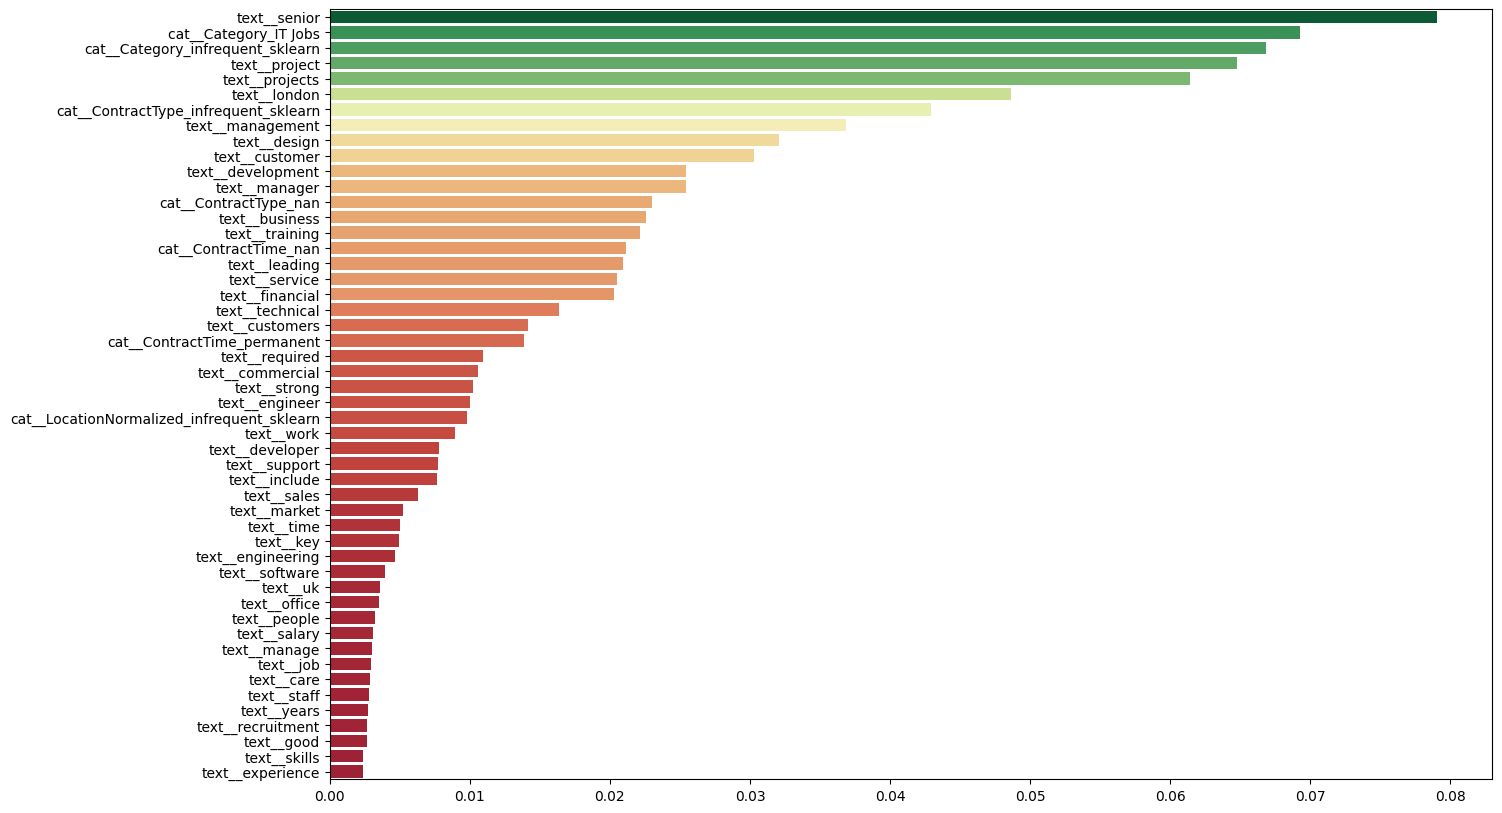

In [44]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(15,10))

tree = model_pipeline[-1]
importances = pd.Series(
    tree.feature_importances_,
    model_pipeline[:-1].get_feature_names_out()
).sort_values(ascending=False)

norm = plt.Normalize(0, importances.max())
colors = plt.cm.RdYlGn(importances.apply(norm))
sns.barplot(x=importances[:50], y=importances.index[:50], ax=ax, palette=colors)

0.3 MAE is the baseline for neural methods.